# [LVV-T1876] - Settling Time After a Slew

Notebook containing data analysis for the [LVV-T1876] test case.  
~The script used to run this test case can be found in [lsst-ts/ts_m1m3supporttesting/M13T012.py].~


[LVV-T1876]: https://jira.lsstcorp.org/secure/Tests.jspa#/testCase/2237
[lsst-ts/ts_m1m3supporttesting/M13T012.py]: https://github.com/lsst-ts/ts_m1m3supporttesting/blob/develop/M13T012.py


see [LVV-T2732_analysis_mt_encoder_slew_jitter.ipynb] for jitter ideas?

[LVV-T2732_analysis_mt_encoder_slew_jitter.ipynb]: https://github.com/lsst-sitcom/notebooks_vandv/blob/develop/notebooks/tel_and_site/subsys_req_ver/tma/LVV-T2732_analysis_mt_encoder_slew_jitter.ipynb


My first thought is we:
1. identify appropriate slew events (?)
2. Compute rms for time window after 'inPosition' log event
3. Define settled when all rms are below some value (not sure what the threshold should be)

Some pending items(May 29th 2023) --> add as issues:
1. Try on real or simulated events
2. Understand IMS input (hardware)
3. Get some RMS requirements, define RMS or alt function
4. Return a settling time value for the function
5. Figure out units (does submicron make any sense)
6. Rolling values for a set time, not number of events

### Prepare Notebook

In [78]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#from astropy import units as u
from astropy.time import Time, TimezoneInfo
from statsmodels.tsa.stattools import adfuller

from lsst.sitcom import vandv
from lsst.ts.idl.enums import MTM1M3
from lsst_efd_client import EfdClient

import identify_slews

In [3]:
#client = vandv.efd.create_efd_client()
client = EfdClient('usdf_efd')

### Define the function

In [218]:
def determineSettleTime(T0_tag = '2023-04-18T16:13:52', 
                        imsColumn = 'xPosition', 
                        rmsReq = 1e-2, 
                        delta_t = 3):

    T0 = pd.to_datetime(T0_tag)
    T1 = T0 + pd.to_timedelta(delta_t,unit='s')
    delta_z = [pd.Timedelta(5, "seconds"),pd.Timedelta(15, "seconds")] #
    TZoom = [T0-delta_z[0], #zoom around the T0 of interest (in position event?)
            T0+delta_z[1]] 
    idx = [df_ims.index[df_ims.index.get_indexer([pd.to_datetime(T0)], method='nearest')],
          df_ims.index[df_ims.index.get_indexer([pd.to_datetime(T1)], method='nearest')],
          df_ims.index[df_ims.index.get_indexer([pd.to_datetime(TZoom[1])], method='nearest')]]    

    pos = (df_ims[imsColumn][TZoom[0]:TZoom[1]] - df_ims[imsColumn][idx[0][0]])#.rolling(100).mean()
    pos_check = (df_ims[imsColumn][idx[0][0]:idx[1][0]] - df_ims[imsColumn][idx[0][0]])
    rms = np.std(pos_check) ## we actually want RMSE around 0 I guess, rather than around mean
                            ## maybe a new function can be created here

    title = imsColumn
    label = imsColumn + '(mm) wrt T0 (slew stop)'

    fig = plt.figure()
    plt.plot(pos[TZoom[0]:TZoom[1]],color='red', lw="0.5", label=label)
    plt.axvline(pd.to_datetime(T0), lw="2", c="k")
    plt.axvline(T1, lw="0.5", c="k")
    #plt.axhline(-req)
    #plt.axhline(req)
    plt.xlabel("Time [UTC]")
    plt.ylabel(label)
    #plt.title(label)
    plt.text(0.55, 0.70, 'RMS =' + '{:.2e}'.format(rms) + ' mm in window', transform=fig.transFigure)
    fig.autofmt_xdate()
    fig.tight_layout()

    rms = (df_ims[imsColumn][T0:TZoom[1]] - df_ims[imsColumn][idx[2][0]]).rolling(20).std()
    plt.plot(rms, label='RMS wrt value at the end of plot')
    plt.axvspan(T0, T1, alpha=0.5, color='green', label='3s tolerance window')
    plt.legend(loc="upper right")

    ## compute time for settling
    fig = plt.figure()    
    rms = rms.dropna() # remove NaNs
    lapse = 100 # to be adjusted
    pvalue = 0.05 ## lower, less tolerant to finding stationarity, to be adjusted
    for i in range(0,len(rms)-lapse):
        adf = adfuller(rms[i:i+lapse], autolag='AIC')
        if adf[1] < pvalue: # is non-stationary if null hypothesis is true (large p-value)
            print(i, i+lapse, adf[1], pvalue)
            print(rms.index[i], rms.index[i+lapse])
            break

    plt.plot(rms)
    fig.autofmt_xdate()
    fig.tight_layout()
    plt.text(0.35, 0.70, 'Settling time (ADF test) =' + rms.index[i+lapse].strftime('%H:%M:%S.%f'), transform=fig.transFigure)        
            
    return rms.index[i+lapse]

### Query Data

In [7]:
all_columns = ["xPosition", "xRotation", "yPosition", "yRotation", "zPosition", "zRotation"]
pos_columns = [c for c in all_columns if "Position" in c]
rot_columns = [c for c in all_columns if "Rotation" in c]
print(pos_columns, rot_columns)

['xPosition', 'yPosition', 'zPosition'] ['xRotation', 'yRotation', 'zRotation']


In [5]:
#define the date
#t_start = "2023-04-18T16:10:00" # Times of force balance test
#t_end = "2023-04-18T16:15:00"
t_start = Time('2023-06-01 06:00:0Z', scale='utc')
t_end = Time('2023-06-01 10:00:0Z', scale='utc') 

### Load data

In [22]:
df_ims = await client.select_time_series(
    "lsst.sal.MTM1M3.imsData", 
    "*", 
    Time(t_start, format="isot", scale="utc"),
    Time(t_end, format="isot", scale="utc"), 
)

df_ims = df_ims.set_index("private_rcvStamp")
df_ims.index = pd.to_datetime(df_ims.index, unit="s")
df_ims = df_ims[all_columns]

df_ims[pos_columns] = df_ims[pos_columns] * 1e3 #to mm
df_ims[rot_columns] = np.rad2deg(df_ims[rot_columns]) #to degrees

### Look at data

In [ ]:
### see ims_elevation_slew_explore

### Run test

In [ ]:
##identify a slew stop
#starts,stops, maxv=identify_slews.get_slews_edge_detection(mtmount["timestamp"],mtmount["actualVelocity"])
#starts,stops = identify_slews.get_slew_pairs(starts,stops)

In [9]:
delta_t = 3 ## seconds
T0_tag = '2023-06-01T06:53:37.326'
req = 1e-2 

10 110 0.03864776131775238 0.05
2023-06-01 06:53:38.027564288 2023-06-01 06:53:40.448126976
<class 'pandas._libs.tslibs.timestamps.Timestamp'>
06:53:40.448126


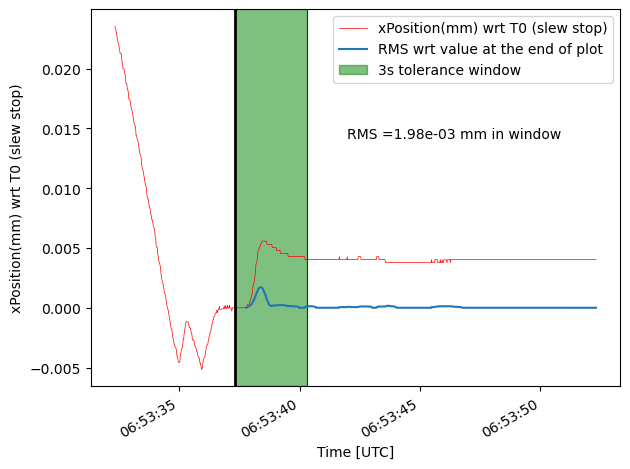

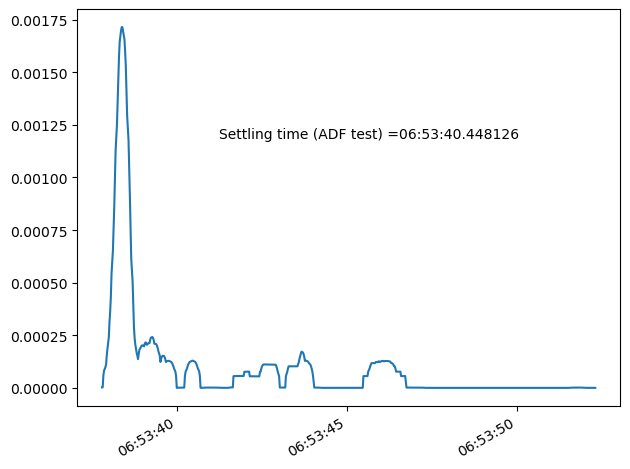

In [219]:
settleTime = determineSettleTime(T0_tag = T0_tag, 
                    imsColumn = 'xPosition', 
                    rmsReq = req, 
                    delta_t = delta_t)
print(type(settleTime))
print(settleTime.strftime('%H:%M:%S.%f'))
#determineSettleTime(T0_tag = T0_tag, 
#                    imsColumn = 'yPosition', 
#                    rmsReq = req, 
#                    delta_t = delta_t)
#determineSettleTime(T0_tag = T0_tag, 
#                   imsColumn = 'zPosition', 
#                    rmsReq = req, 
#                    delta_t = delta_t)

In [175]:
print(rms[4:])
print(rms.index[4])

private_rcvStamp
2023-06-01 06:53:37.887515904    9.823679e-05
2023-06-01 06:53:37.907590400    1.115244e-04
2023-06-01 06:53:37.927595264    1.548818e-04
2023-06-01 06:53:37.947571712    1.858481e-04
2023-06-01 06:53:37.987558656    2.403368e-04
                                     ...     
2023-06-01 06:54:07.211191296    1.433275e-07
2023-06-01 06:54:07.231172096    1.433275e-07
2023-06-01 06:54:07.251180032    1.433275e-07
2023-06-01 06:54:07.291187200    1.433275e-07
2023-06-01 06:54:07.311233792    1.433275e-07
Name: xPosition, Length: 1216, dtype: float64
2023-06-01 06:53:37.887515904


In [ ]:
#### Check a the contents of the pos array
pd.set_option('display.max_rows', 500)
print(pos_check)
print(np.std(pos_check))

In [ ]:
### Overplotting all columns
fig = plt.figure()

xpos = (df_ims['xPosition'] - df_ims['xPosition'][0]).rolling(100).mean()
ypos = (df_ims['yPosition'] - df_ims['yPosition'][0]).rolling(100).mean()
zpos = (df_ims['zPosition'] - df_ims['zPosition'][0]).rolling(100).mean()
xrot = (df_ims['xRotation'] - df_ims['xRotation'][0]).rolling(100).mean()
yrot = (df_ims['yRotation'] - df_ims['yRotation'][0]).rolling(100).mean()
zrot = (df_ims['zRotation'] - df_ims['zRotation'][0]).rolling(100).mean()
plt.plot(xpos,color='red', lw="0.5", label='xPosition (mm) wrt T0')
plt.plot(ypos,color='blue', lw="0.5", label='yPosition (mm) wrt T0')
plt.plot(zpos,color='green', lw="0.5", label='zPosition (mm) wrt T0')
#plt.plot(xrot,color='red', lw="0.5", linestyle='dashed', label='xRotation (degrees) wrt T0')
#plt.plot(yrot,color='blue', lw="0.5", linestyle='dashed', label='yRotation (degrees) wrt T0')
#plt.plot(zrot,color='green', lw="0.5", linestyle='dashed', label='zRotation (degrees) wrt T0')
plt.legend(ncols=2, loc="upper right", bbox_to_anchor=(0.80, 1.3))
plt.xlabel("Time [UTC]")
fig.autofmt_xdate()
fig.tight_layout()

In [ ]:
df_ims = await client.select_time_series(
    "lsst.sal.MTM1M3.imsData", 
    "*", 
    Time(t_start, format="isot", scale="utc"),
    Time(t_end, format="isot", scale="utc"), 
)
print(df_ims)